## Business Understanding

Bank menerima ribuan aplikasi kartu kredit setiap hari. Mengevaluasi kelayakan kredit secara manual menyita waktu dan rentan error. Oleh karena itu, model prediksi dapat membantu menilai kelayakan kredit secara otomatis dan cepat.

**Masalah yang ingin diselesaikan:**  
Bagaimana memprediksi apakah pemohon kartu kredit layak mendapatkan persetujuan berdasarkan data aplikasi dan riwayat kredit?

**Tujuan bisnis:**
- Menyaring aplikasi berisiko tinggi
- Mempercepat proses persetujuan
- Mengurangi kredit macet

In [ ]:
# Pipeline and K-Fold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Additional Metrics (jika digunakan dalam evaluasi)
from sklearn.metrics import accuracy_score

# === Data Manipulation & Visualization ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

# === Preprocessing & Sampling ===
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE

# === Models ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === Baseline & Evaluation ===
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    accuracy_score
)

# === Multicollinearity (VIF) ===
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# === Pipeline ===
from sklearn.pipeline import Pipeline

## Data Understanding

Dataset terdiri dari dua bagian:
- `application_record.csv`: Informasi pribadi dan finansial pemohon (fitur)
- `credit_record.csv`: Riwayat pembayaran pemohon terhadap pinjaman sebelumnya (label)

Langkah ini mencakup:
- Memahami tipe dan isi kolom
- Menilai jumlah missing values
- Menjelajahi distribusi data

In [ ]:
# === 1. Load Dataset ===
app_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

In [ ]:
print(app_df.shape)

(438557, 18)


In [ ]:
print(credit_df.shape)

(1048575, 3)


In [ ]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
credit_df['STATUS'].value_counts(normalize=True)

,proportion
STATUS,
C,0.421554
0,0.365372
X,0.199537
1,0.010576
5,0.001615
2,0.000828
3,0.000305
4,0.000213


## Check data types and missing values

In [ ]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
app_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [ ]:
app_df.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
app_df['FLAG_MOBIL'].value_counts(normalize=True)

,proportion
FLAG_MOBIL,
1,1.0


In [ ]:
app_df['FLAG_OWN_CAR'].value_counts(normalize=True)

,proportion
FLAG_OWN_CAR,
N,0.628103
Y,0.371897


In [ ]:
app_df = app_df.drop(columns=['FLAG_MOBIL'])

In [ ]:
mode_occ = app_df['OCCUPATION_TYPE'].mode()[0]
app_df['OCCUPATION_TYPE'].fillna(mode_occ, inplace=True)

/tmp/ipython-input-3577797006.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_df['OCCUPATION_TYPE'].fillna(mode_occ, inplace=True)


In [ ]:
app_df.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
app_df['OCCUPATION_TYPE'].value_counts(normalize=True)

,proportion
OCCUPATION_TYPE,
Laborers,0.484414
Core staff,0.098065
Sales staff,0.093712
Managers,0.080918
Drivers,0.059491
High skill tech staff,0.039422
Accountants,0.036449
Medicine staff,0.030828
Cooking staff,0.018415


In [ ]:
app_df.duplicated().sum()

np.int64(0)

In [ ]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [ ]:
credit_df.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [ ]:
credit_df.isnull().sum()

,0
ID,0
MONTHS_BALANCE,0
STATUS,0


In [ ]:
app_df.duplicated().sum()

np.int64(0)

# Data Preparation

Tahapan ini mencakup:
- Menggabungkan `application_record` dan `credit_record`
- Menangani missing values
- Encoding kategorikal
- Feature selection
- Menyeimbangkan data menggunakan SMOTE

In [ ]:
credit_df['STATUS'] = credit_df['STATUS'].replace(['X', 'C'], '0').astype(int)
credit_df['approved'] = credit_df['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
label_df = credit_df.groupby('ID')['approved'].max().reset_index()
label_df['approved'] = label_df['approved'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
month_stat_df = credit_df.groupby('ID')['MONTHS_BALANCE'].agg(['min',
                                                               'max',
                                                               'mean',
                                                               'count']).reset_index()
month_stat_df.columns = ['ID', 'MB_min', 'MB_max', 'MB_mean', 'MB_count']

In [ ]:
df = app_df.merge(label_df, on='ID', how='inner')
df = df.merge(month_stat_df, on='ID', how='left')

In [ ]:
# Mapping 1 -> Yes, 0 -> No on the merged dataframe
df['approved'] = df['approved'].map({1: 'Yes', 0: 'No'})

| Kolom         | Penjelasan                                                                                                                                                                                              |
| ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **MB\_min**   | Bulan terlama sejak kredit aktif yang tercatat (paling jauh ke belakang). Biasanya bernilai negatif besar. Misal `-29` artinya data dari 29 bulan yang lalu.                                            |
| **MB\_max**   | Bulan terbaru yang tercatat dalam histori kredit. Biasanya `0`, artinya data bulan ini (saat pengambilan data). Jika nilainya negatif, misalnya `-1`, berarti data terakhir tercatat sebulan yang lalu. |
| **MB\_mean**  | Rata-rata dari nilai `MONTHS_BALANCE`. Ini menunjukkan **pusat waktu** dari histori kredit pelanggan. Misalnya `-7.5` berarti data kredit nasabah sebagian besar sekitar 7.5 bulan yang lalu.           |
| **MB\_count** | Jumlah bulan riwayat kredit yang tersedia untuk nasabah tersebut. Misalnya `30` artinya ada 30 baris (bulan) histori kredit untuk ID tersebut. Ini mengindikasikan **durasi histori kredit**.           |


In [ ]:
df['approved'].value_counts(normalize=True)

,proportion
approved,
Yes,0.8823
No,0.1177


In [ ]:
df.isna().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_WORK_PHONE      36457 non-null  int64  
 13  FLAG_PHONE           36457 non-null  int64  
 14  FLAG_EMAIL           36457 non-null  int64  
 15  OCCUPATION_TYPE      36457 non-null 

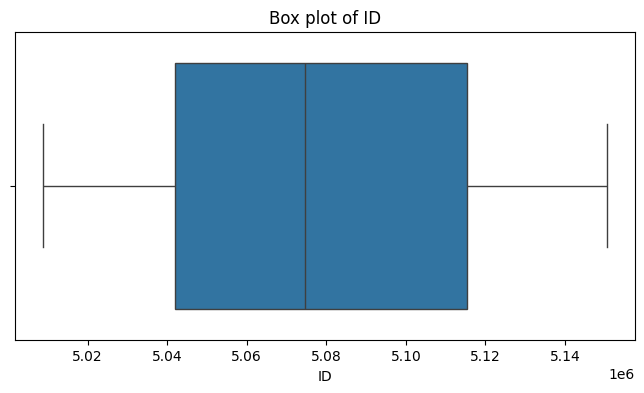

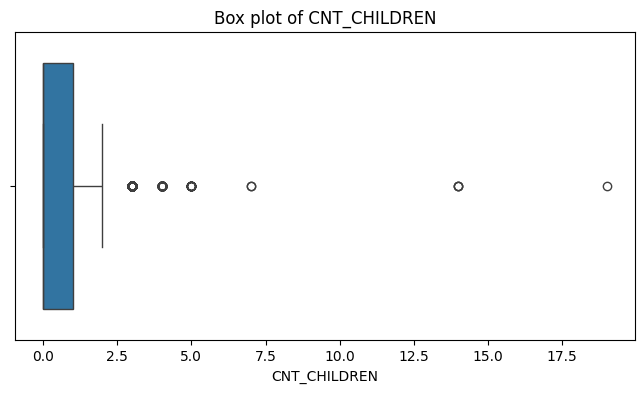

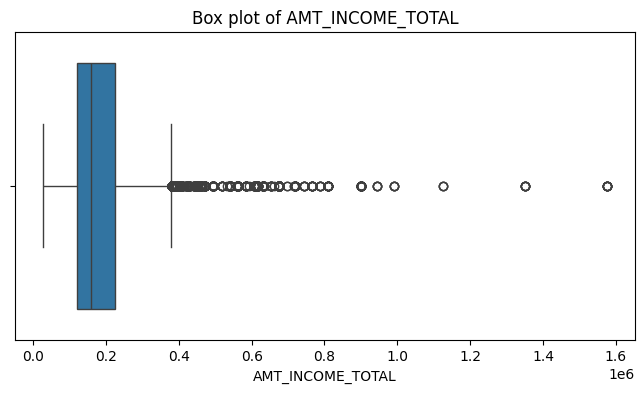

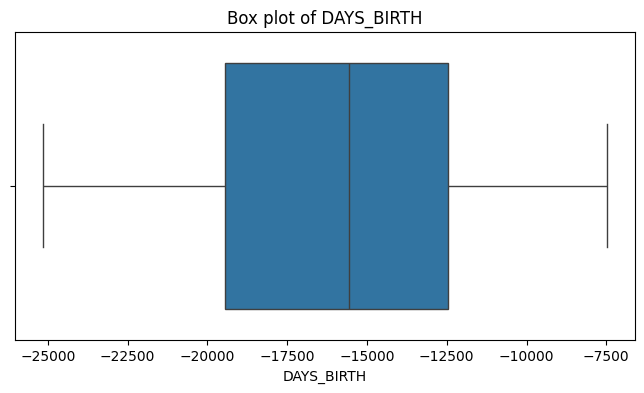

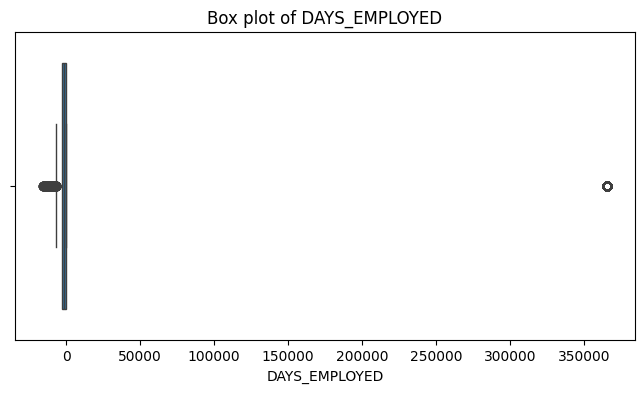

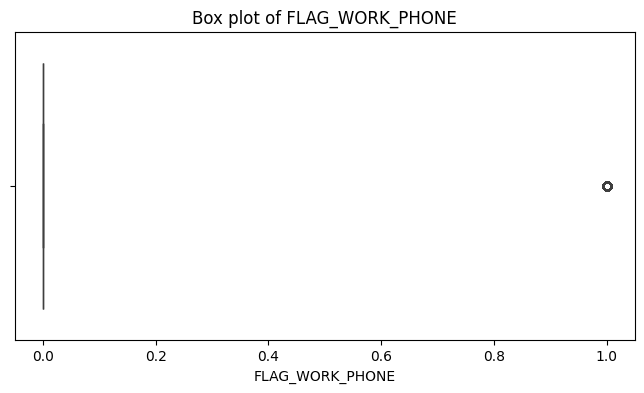

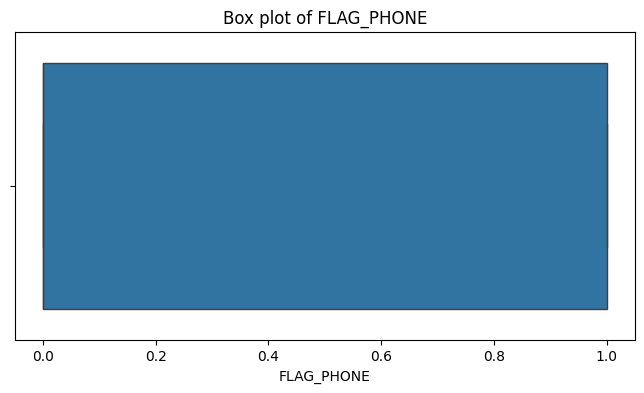

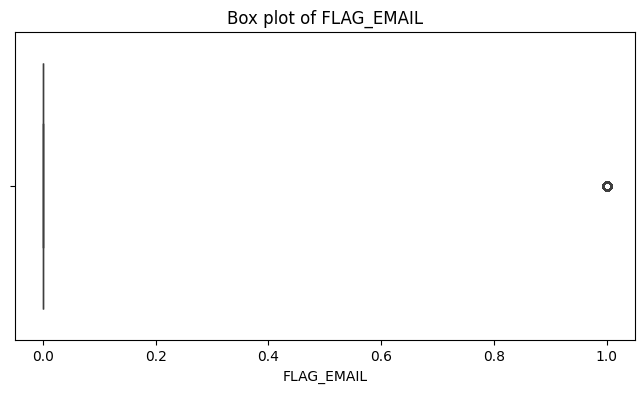

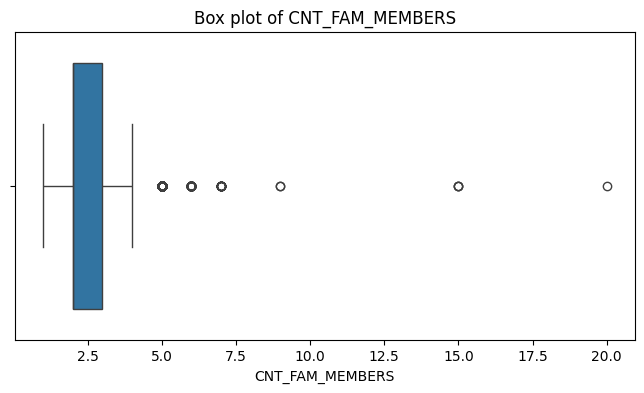

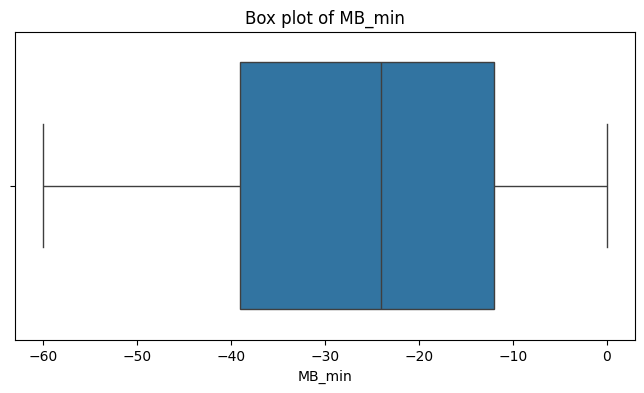

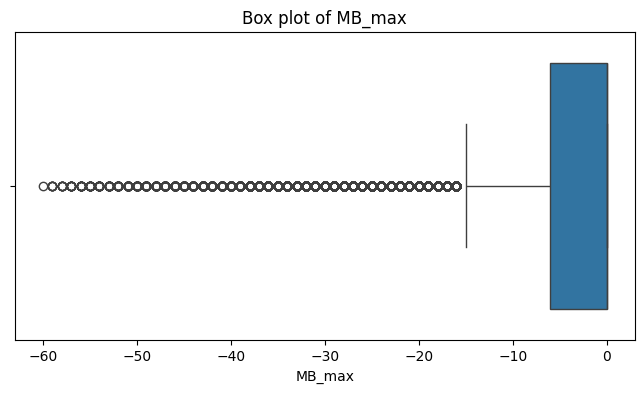

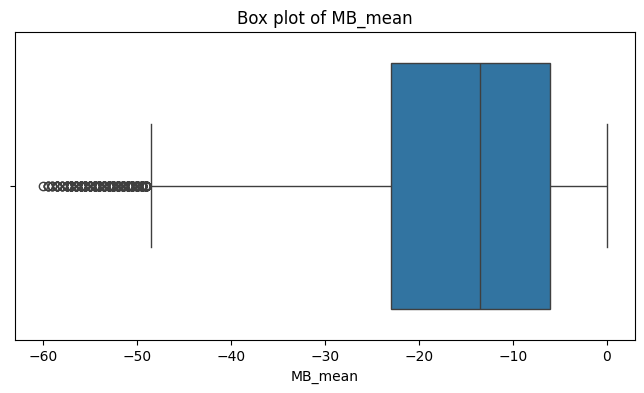

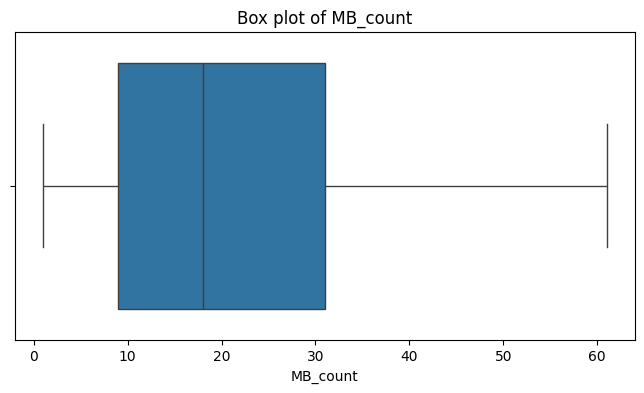

In [ ]:
# cek outlier dari data

# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Example usage for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

import matplotlib.pyplot as plt
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

## === Feature Engineering ===

In [ ]:
df['DAYS_EMPLOYED'].value_counts(normalize=True)

,proportion
DAYS_EMPLOYED,
365243,0.168280
-401,0.002140
-1539,0.001755
-200,0.001728
-2087,0.001673
...,...
-2394,0.000027
-4770,0.000027
-3182,0.000027


In [ ]:
df['AGE'] = (-df['DAYS_BIRTH'] / 365).astype(int)
df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED'] / 365).astype(int)

In [ ]:
df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

In [ ]:
df['YEARS_EMPLOYED'].value_counts(normalize=True)

,proportion
YEARS_EMPLOYED,
-1000,0.168280
1,0.088735
4,0.078970
3,0.077653
2,0.075788
0,0.069671
6,0.058425
5,0.056423
8,0.050196


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  FLAG_WORK_PHONE      36457 non-null  int64  
 11  FLAG_PHONE           36457 non-null  int64  
 12  FLAG_EMAIL           36457 non-null  int64  
 13  OCCUPATION_TYPE      36457 non-null  object 
 14  CNT_FAM_MEMBERS      36457 non-null  float64
 15  approved             36457 non-null 

In [ ]:
df['CNT_FAM_MEMBERS'].value_counts(normalize=True)

,proportion
CNT_FAM_MEMBERS,
2.0,0.533862
1.0,0.191650
3.0,0.176125
4.0,0.085196
5.0,0.010890
6.0,0.001591
7.0,0.000521
15.0,0.000082
9.0,0.000055


In [ ]:
# Tangani nilai -1000 pada YEARS_EMPLOYED
df['IS_WORKING'] = df['YEARS_EMPLOYED'].apply(lambda x: 0 if x == -1000 else 1)
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].replace(-1000, np.nan)
median_employed = df.loc[df['IS_WORKING'] == 1, 'YEARS_EMPLOYED'].median()
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(median_employed)

In [ ]:
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].round().astype(int)
df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 0, 'F': 1})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1})

In [ ]:
bins = [0, 100000, 150000, 200000, 300000, float('inf')]
labels = ['<100K', '100-150K', '150-200K', '200-300K', '300K+']
df['income_bin'] = pd.cut(df['AMT_INCOME_TOTAL'], bins=bins, labels=labels)

In [ ]:
df['age_group'] = pd.cut(df['AGE'],
                         bins=[20, 30, 40, 50, 60, 70],
                         labels=['20-30', '30-40', '40-50', '50-60', '60-70'],
                         right=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   36457 non-null  int64   
 1   CODE_GENDER          36457 non-null  int64   
 2   FLAG_OWN_CAR         36457 non-null  int64   
 3   FLAG_OWN_REALTY      36457 non-null  int64   
 4   CNT_CHILDREN         36457 non-null  int64   
 5   AMT_INCOME_TOTAL     36457 non-null  float64 
 6   NAME_INCOME_TYPE     36457 non-null  object  
 7   NAME_EDUCATION_TYPE  36457 non-null  object  
 8   NAME_FAMILY_STATUS   36457 non-null  object  
 9   NAME_HOUSING_TYPE    36457 non-null  object  
 10  FLAG_WORK_PHONE      36457 non-null  int64   
 11  FLAG_PHONE           36457 non-null  int64   
 12  FLAG_EMAIL           36457 non-null  int64   
 13  OCCUPATION_TYPE      36457 non-null  object  
 14  CNT_FAM_MEMBERS      36457 non-null  int64   
 15  approved           

In [ ]:
df.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
# Cek tipe fitur
cat_cols = df.select_dtypes('object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID']).columns.tolist()
print("Fitur kategorikal:", cat_cols)
print("Fitur numerik:", num_cols)

Fitur kategorikal: ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'approved']
Fitur numerik: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MB_min', 'MB_max', 'MB_mean', 'MB_count', 'AGE', 'YEARS_EMPLOYED', 'IS_WORKING']


# Exploratory Data Analysis (EDA)

Visualisasi seperti:
- Distribusi `AMT_INCOME_TOTAL` terhadap `CODE_GENDER`
- Boxplot pendapatan terhadap jenis pekerjaan
- Countplot status keluarga dan pendidikan
- Korelasi usia terhadap label persetujuan
telah memberikan wawasan penting untuk feature selection dan model interpretasi.

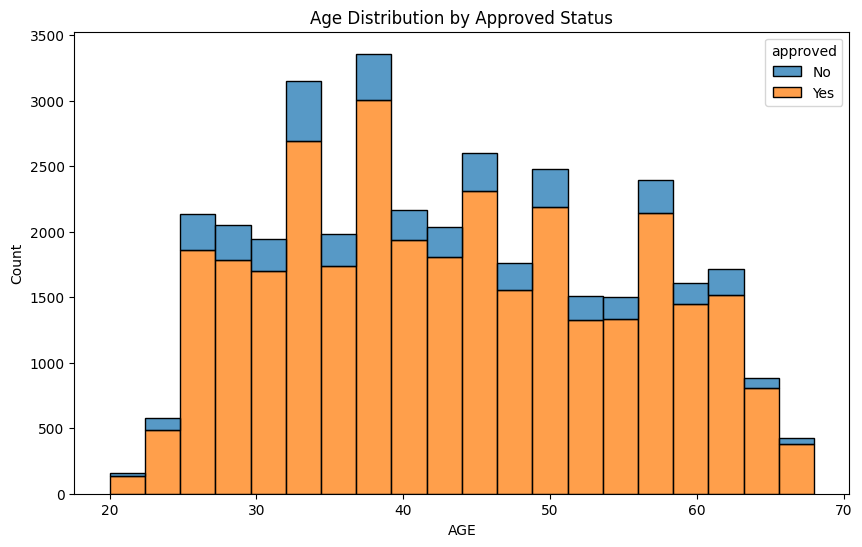

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='AGE', hue='approved', multiple='stack', bins=20)
plt.title('Age Distribution by Approved Status')
plt.xlabel('AGE')
plt.ylabel('Count')
plt.show()

In [ ]:
approved_by_age = df.groupby('age_group')['approved'].value_counts(normalize=True).unstack().fillna(0)
approved_by_age['Approved_Rate'] = approved_by_age['Yes']
print("\nApproved Rate by Age Group:")
print(approved_by_age[['Approved_Rate']])


Approved Rate by Age Group:
approved   Approved_Rate
age_group               
20-30           0.866477
30-40           0.875527
40-50           0.888638
50-60           0.888204
60-70           0.893445


/tmp/ipython-input-3661631119.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approved_by_age = df.groupby('age_group')['approved'].value_counts(normalize=True).unstack().fillna(0)


**Insight dari Distribusi Usia dan Kelayakan Kredit**

- Mayoritas pemohon kredit berada di rentang usia 30 hingga 60 tahun, dengan puncaknya di sekitar usia 35–45 tahun.

- Tingkat kelayakan (approved rate) meningkat seiring bertambahnya usia, dari 86.37% di usia 20–30 tahun menjadi 89.52% di kelompok usia 60–70 tahun.

- Kelompok usia 70–80 tahun tidak memiliki data kelayakan, kemungkinan karena jumlah data yang sangat sedikit atau tidak ada.

Pemohon berusia di atas 40 tahun cenderung lebih layak mendapatkan persetujuan kredit dibanding yang lebih muda. Strategi pemasaran dan penawaran produk kredit bisa difokuskan pada kelompok usia 40–70 tahun untuk meningkatkan persetujuan aplikasi.



In [ ]:
df['NAME_INCOME_TYPE'].value_counts(normalize=True)

,proportion
NAME_INCOME_TYPE,
Working,0.516197
Commercial associate,0.232877
Pensioner,0.168747
State servant,0.081877
Student,0.000302


In [ ]:
df['NAME_EDUCATION_TYPE'].value_counts(normalize=True)

,proportion
NAME_EDUCATION_TYPE,
Secondary / secondary special,0.679623
Higher education,0.270565
Incomplete higher,0.038676
Lower secondary,0.010259
Academic degree,0.000878


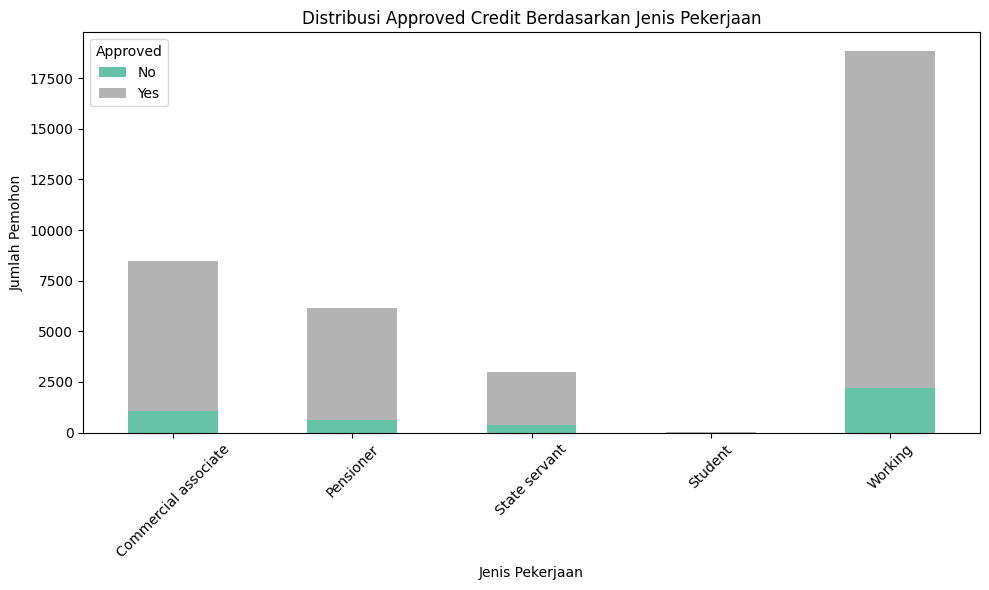

In [ ]:
# Hitung jumlah data per kategori pendidikan dan status approval
edu_approval = df.groupby(['NAME_INCOME_TYPE', 'approved']).size().unstack(fill_value=0)

# Buat stacked bar chart
edu_approval.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

# Tambahkan label dan judul
plt.title('Distribusi Approved Credit Berdasarkan Jenis Pekerjaan')
plt.xlabel('Jenis Pekerjaan')
plt.ylabel('Jumlah Pemohon')
plt.xticks(rotation=45)
plt.legend(title='Approved')
plt.tight_layout()
plt.show()

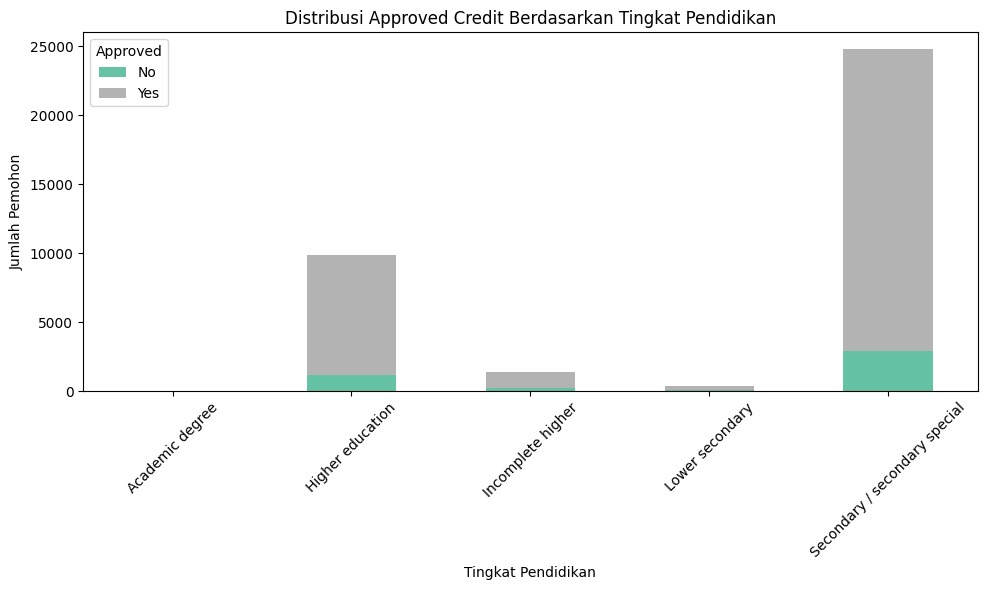

In [ ]:
# Hitung jumlah data per kategori pendidikan dan status approval
edu_approval = df.groupby(['NAME_EDUCATION_TYPE', 'approved']).size().unstack(fill_value=0)

# Buat stacked bar chart
edu_approval.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

# Tambahkan label dan judul
plt.title('Distribusi Approved Credit Berdasarkan Tingkat Pendidikan')
plt.xlabel('Tingkat Pendidikan')
plt.ylabel('Jumlah Pemohon')
plt.xticks(rotation=45)
plt.legend(title='Approved')
plt.tight_layout()
plt.show()

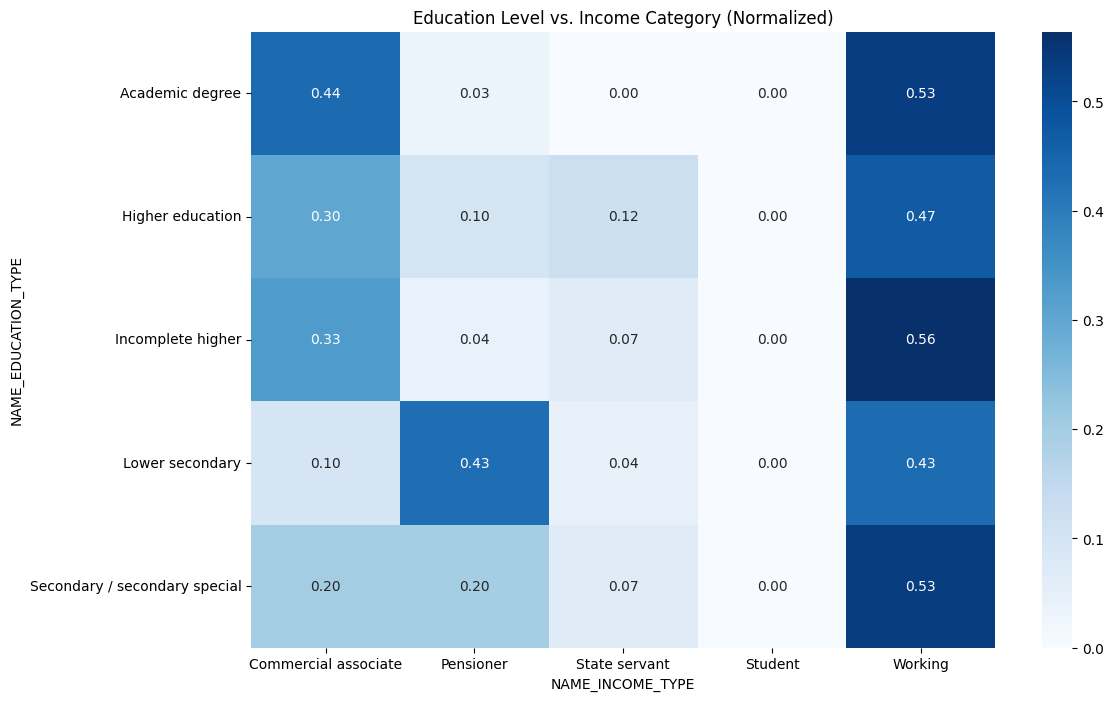

In [ ]:
# Education Level and Income Category vs. Churn
edu_income = pd.crosstab(df['NAME_EDUCATION_TYPE'], df['NAME_INCOME_TYPE'], normalize='index')
plt.figure(figsize=(12, 8))
sns.heatmap(edu_income, annot=True, cmap='Blues', fmt='.2f')
plt.title('Education Level vs. Income Category (Normalized)')
plt.show()

**Heatmap: Education Level vs Income Category (Normalized)**

Gambar heatmap menunjukkan proporsi distribusi pendidikan terhadap masing-masing kategori penghasilan. Beberapa insight penting:

Pemohon dengan pendidikan "Academic degree" paling banyak berada di kategori:

- Working (53%)

- Commercial associate (44%)

Pemohon "Incomplete higher education" mayoritas dari:

- Working (56%)

- Lower secondary paling besar proporsinya di:

- Pensioner (43%)

Hampir semua tingkat pendidikan tidak memiliki representasi di kategori "Student", sesuai dengan proporsi kecilnya (0.03%).

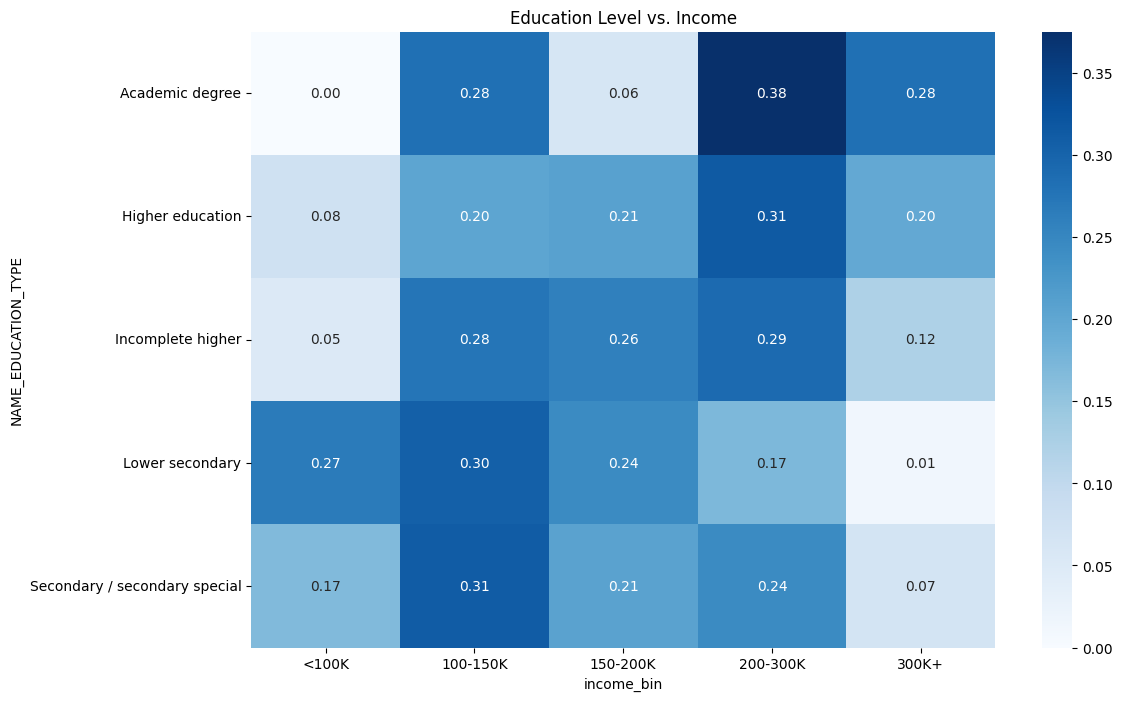

In [ ]:
# Education Level and Income Category vs. Churn
edu_income = pd.crosstab(df['NAME_EDUCATION_TYPE'], df['income_bin'], normalize='index')
plt.figure(figsize=(12, 8))
sns.heatmap(edu_income, annot=True, cmap='Blues', fmt='.2f')
plt.title('Education Level vs. Income')
plt.show()

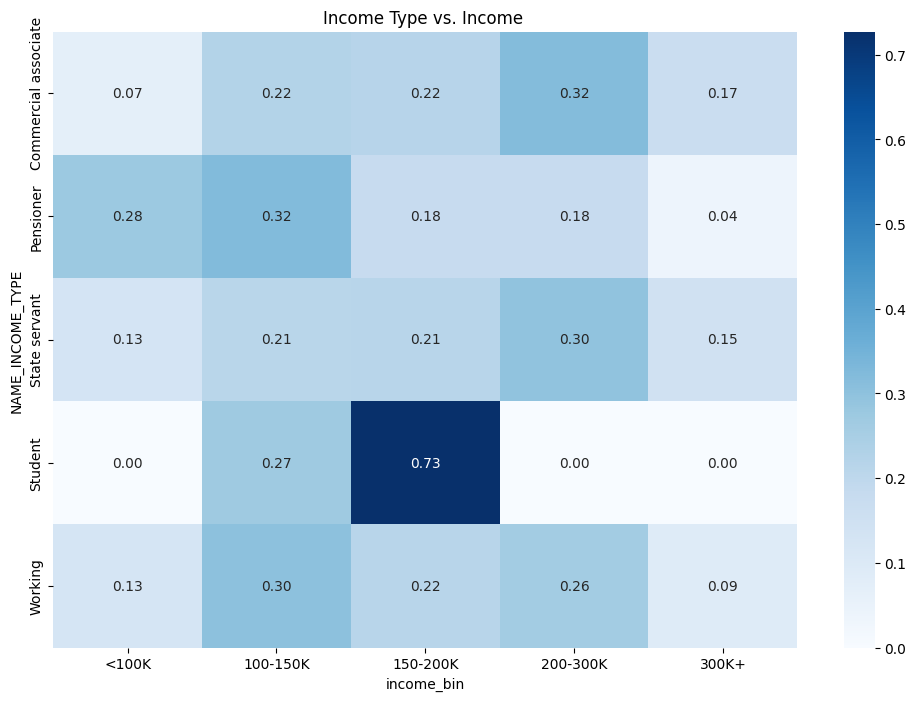

In [ ]:
# Education Level and Income Category vs. Churn
edu_income = pd.crosstab(df['NAME_INCOME_TYPE'], df['income_bin'], normalize='index')
plt.figure(figsize=(12, 8))
sns.heatmap(edu_income, annot=True, cmap='Blues', fmt='.2f')
plt.title('Income Type vs. Income ')
plt.show()

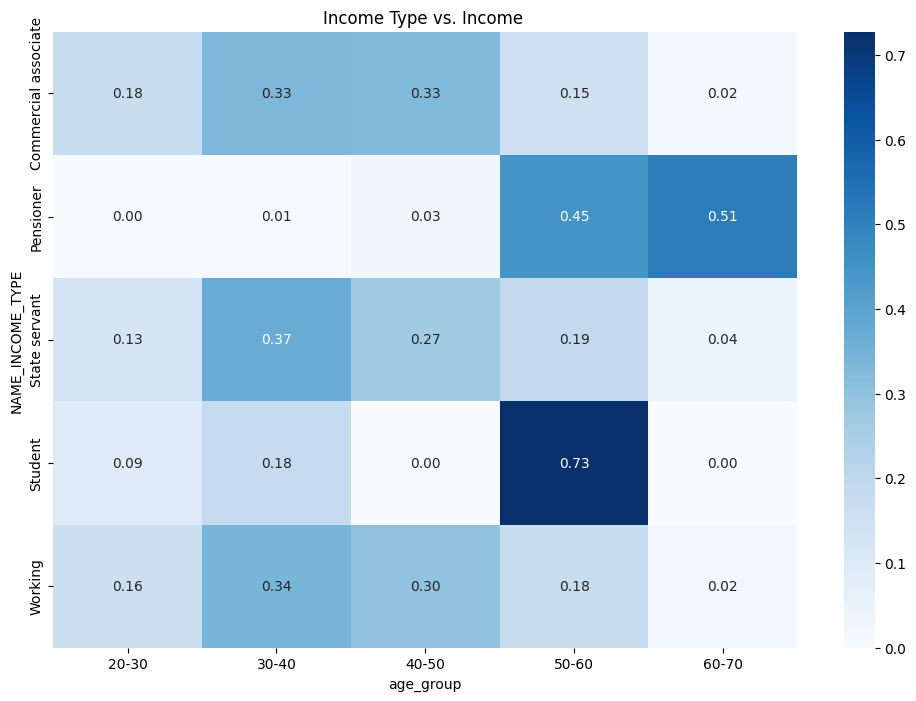

In [ ]:
# Education Level and Income Category vs. Churn
edu_income = pd.crosstab(df['NAME_INCOME_TYPE'], df['age_group'], normalize='index')
plt.figure(figsize=(12, 8))
sns.heatmap(edu_income, annot=True, cmap='Blues', fmt='.2f')
plt.title('Income Type vs. Income ')
plt.show()

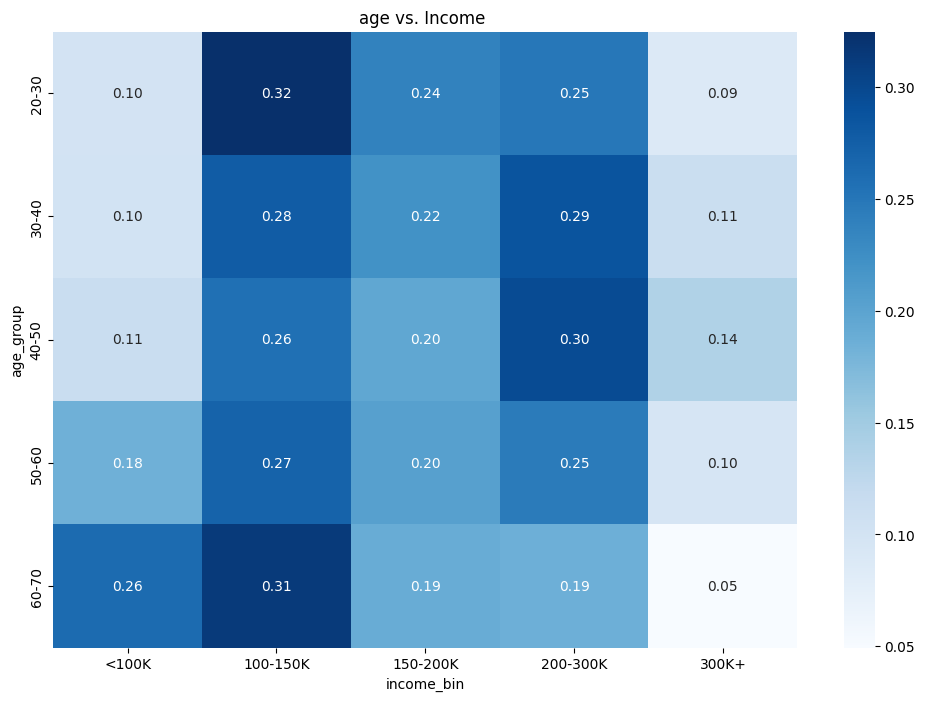

In [ ]:
# Education Level and Income Category vs. Churn
edu_income = pd.crosstab(df['age_group'], df['income_bin'], normalize='index')
plt.figure(figsize=(12, 8))
sns.heatmap(edu_income, annot=True, cmap='Blues', fmt='.2f')
plt.title('age vs. Income ')
plt.show()

In [ ]:
approved_by_income = df.groupby('NAME_INCOME_TYPE')['approved'].value_counts(normalize=True).unstack().fillna(0)
print("\nApproved Rate by Education Level:")
print(approved_by_income[['Yes']])


Approved Rate by Education Level:
approved                   Yes
NAME_INCOME_TYPE              
Commercial associate  0.872792
Pensioner             0.895319
State servant         0.871022
Student               0.909091
Working               0.884106


**Insight dari Income Type vs Approved Rate**

- Mahasiswa (Student) memiliki approved rate tertinggi, yakni 90.9%, namun perlu diperhatikan bahwa jumlah mereka sangat kecil dalam data (hanya 0.03% dari total populasi).

- Kelompok Pensiunan (Pensioner) juga memiliki tingkat persetujuan yang tinggi, yaitu 89.5%, dan mencakup 16.9% dari populasi.

- Approved rate terendah ditemukan pada kelompok State Servant (87.1%) dan Commercial Associate (87.3%).

- Kelompok Working, yang mendominasi data dengan proporsi 51.6%, memiliki approval rate tinggi yaitu 88.4%.

**Kesimpulan:** Kelompok Pensioner dan Working menunjukkan kecenderungan disetujui lebih tinggi daripada beberapa kelompok pekerja formal lainnya, kemungkinan karena stabilitas pendapatan atau profil risiko yang lebih rendah.

In [ ]:
approved_by_edu = df.groupby('NAME_EDUCATION_TYPE')['approved'].value_counts(normalize=True).unstack().fillna(0)
print("\nApproved Rate by Income Category:")
print(approved_by_edu[['Yes']])


Approved Rate by Income Category:
approved                            Yes
NAME_EDUCATION_TYPE                    
Academic degree                0.781250
Higher education               0.883617
Incomplete higher              0.853191
Lower secondary                0.895722
Secondary / secondary special  0.883360


**Insight dari Education Level vs Approved Rate**

- Pendidikan dengan approval rate tertinggi adalah Lower Secondary (89.6%), namun hanya mewakili 1.03% dari populasi, sehingga kurang signifikan secara populasi.

- Kelompok terbesar adalah Secondary / Secondary Special, mencakup 67.9% dari populasi, dengan approval rate tinggi yaitu 88.3%.

- Approval rate tertinggi kedua berasal dari Higher Education (88.4%), yang mencakup sekitar 27% dari total data.

- Academic Degree memiliki approval rate paling rendah (78.1%) dan juga merupakan kelompok paling kecil (0.09% dari data).

**Kesimpulan:** Meskipun beberapa kelompok pendidikan menunjukkan approval rate ekstrem, kelompok seperti Secondary dan Higher Education adalah yang paling relevan secara bisnis karena kombinasi antara jumlah besar dan tingkat persetujuan tinggi.

In [ ]:
df['CODE_GENDER'].value_counts(normalize=True)

,proportion
CODE_GENDER,
1,0.670105
0,0.329895


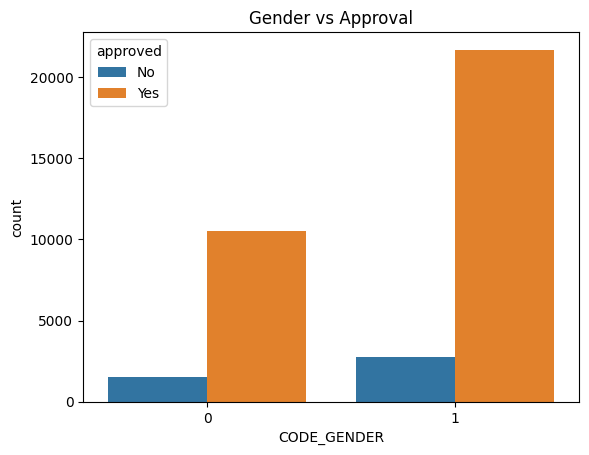

In [ ]:
sns.countplot(x='CODE_GENDER', hue='approved', data=df)
plt.title('Gender vs Approval')
plt.show()

In [ ]:
# Approved by Gender
approved_by_gender = df.groupby('CODE_GENDER')['approved'].value_counts(normalize=True).unstack().fillna(0)
print("\nApproved Rate by Gender:")
print(approved_by_gender[['Yes']])


Approved Rate by Gender:
approved          Yes
CODE_GENDER          
0            0.872537
1            0.887106


**Insight dari Gender vs Approved Rate**
- Perempuan memiliki tingkat persetujuan aplikasi yang lebih tinggi (88.71%) dibandingkan laki-laki (87.25%).

- Grafik juga menunjukkan bahwa jumlah pemohon perempuan jauh lebih banyak daripada laki-laki.

- Meskipun secara total persetujuan lebih banyak karena populasi perempuan lebih besar, secara proporsi pun perempuan tetap memiliki approved rate yang lebih baik.

Gender tampaknya berpengaruh terhadap persetujuan aplikasi. Perempuan cenderung memiliki profil risiko yang lebih rendah atau lebih sesuai dengan kriteria persetujuan dibandingkan laki-laki dalam dataset ini.

/tmp/ipython-input-3501775667.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CODE_GENDER', y='AMT_INCOME_TOTAL', data=app_df, estimator='mean', palette={'M': 'blue', 'F': 'orange'})


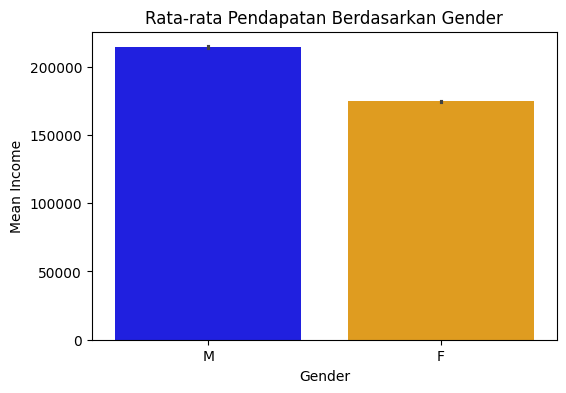

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x='CODE_GENDER', y='AMT_INCOME_TOTAL', data=app_df, estimator='mean', palette={'M': 'blue', 'F': 'orange'})
plt.title('Rata-rata Pendapatan Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Income')
plt.show()

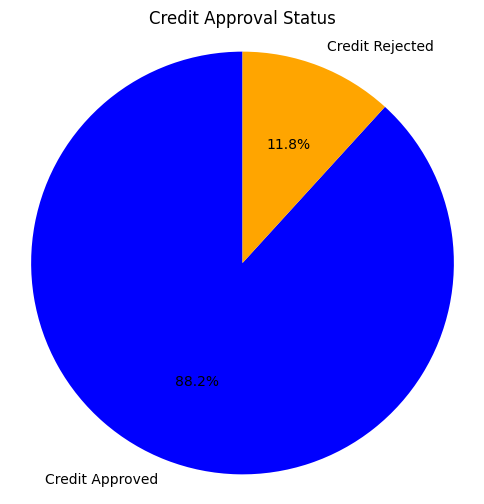

In [ ]:
label_counts = df['approved'].value_counts(normalize=True)
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['Credit Approved', 'Credit Rejected'], colors=['blue', 'orange'], autopct='%1.1f%%', startangle=90)
plt.title("Credit Approval Status")
plt.axis('equal')
plt.show()

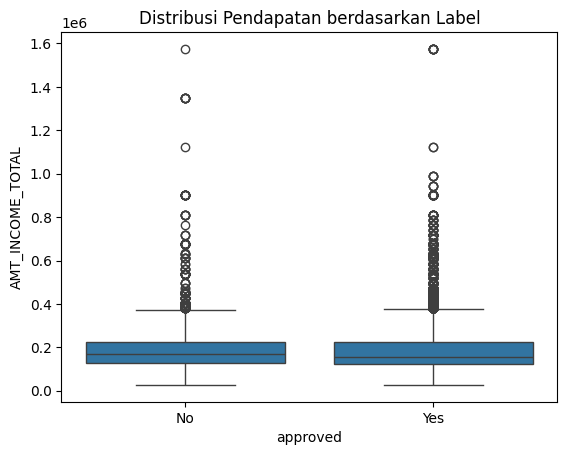

In [ ]:
sns.boxplot(x='approved', y='AMT_INCOME_TOTAL', data=df)
plt.title('Distribusi Pendapatan berdasarkan Label')
plt.show()


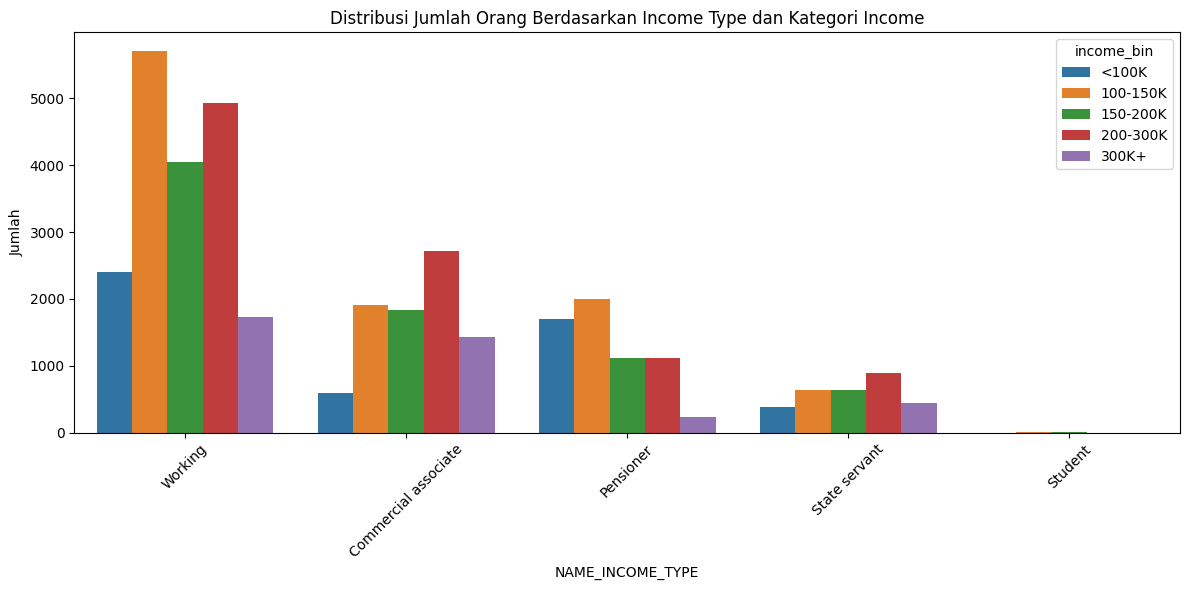

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='NAME_INCOME_TYPE', hue='income_bin')
plt.title('Distribusi Jumlah Orang Berdasarkan Income Type dan Kategori Income')
plt.ylabel('Jumlah')
plt.xlabel('NAME_INCOME_TYPE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-111106418.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approved_by_income_bin = df.groupby('income_bin')['approved'].value_counts(normalize=True).unstack().fillna(0)
/tmp/ipython-input-111106418.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


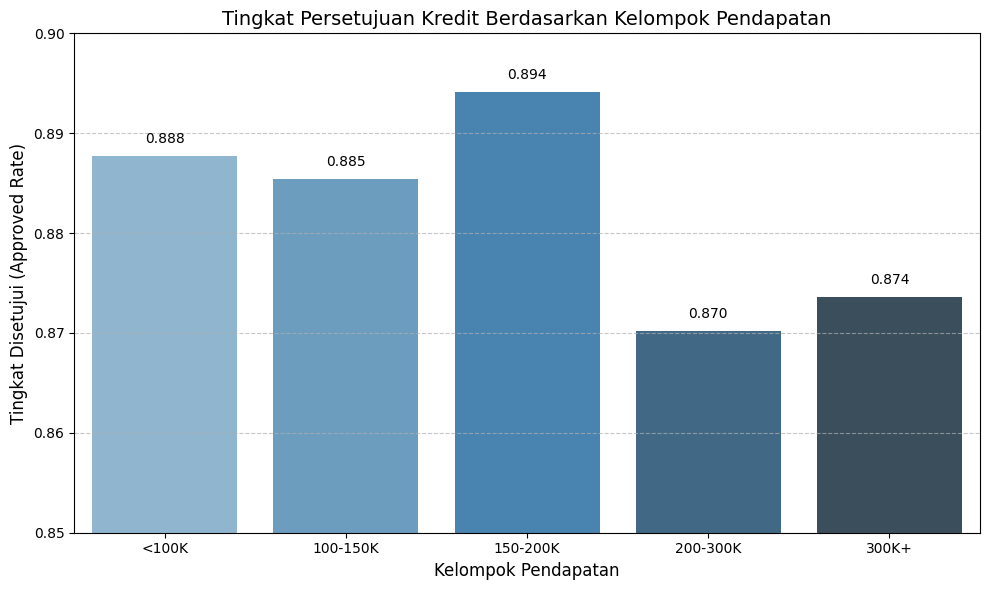

In [ ]:
approved_by_income_bin = df.groupby('income_bin')['approved'].value_counts(normalize=True).unstack().fillna(0)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x=approved_by_income_bin.index,
    y=approved_by_income_bin['Yes'],
    palette="Blues_d"
)

# --- Tambahkan label dan judul ---
plt.title('Tingkat Persetujuan Kredit Berdasarkan Kelompok Pendapatan', fontsize=14)
plt.xlabel('Kelompok Pendapatan', fontsize=12)
plt.ylabel('Tingkat Disetujui (Approved Rate)', fontsize=12)
plt.ylim(0.85, 0.90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Tampilkan nilai di atas bar ---
for i, val in enumerate(approved_by_income_bin['Yes']):
    plt.text(i, val + 0.001, f"{val:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Insight dari Income Bin vs Approved Rate**

- Pelanggan dengan pendapatan 150K–200K memiliki tingkat persetujuan tertinggi, yaitu 89.4%.

- Sementara itu, pelanggan dengan pendapatan 200K–300K memiliki approved rate terendah, yakni sekitar 87.0%.

- Pelanggan berpendapatan <100K dan 300K+ memiliki approved rate cukup baik, masing-masing sekitar 88.7% dan 87.5%.

Kelompok dengan pendapatan menengah cenderung lebih mudah mendapatkan persetujuan aplikasi dibanding kelompok berpendapatan sangat rendah atau sangat tinggi.

/tmp/ipython-input-1341805139.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='approved', y=feature, data=df, palette="Set2")
/tmp/ipython-input-1341805139.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='approved', y=feature, data=df, palette="Set2")
/tmp/ipython-input-1341805139.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='approved', y=feature, data=df, palette="Set2")
/tmp/ipython-input-1341805139.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign

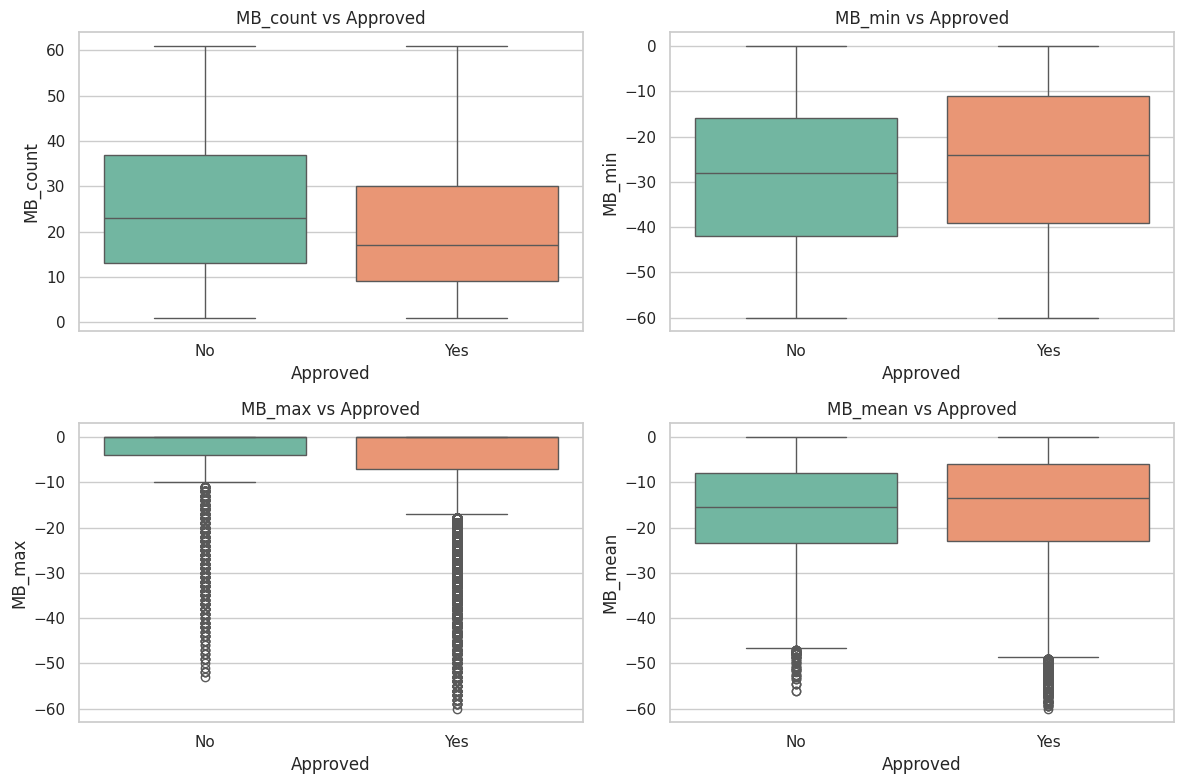

In [ ]:
# Set tema visual seaborn
sns.set(style="whitegrid")

# Daftar fitur yang ingin dibandingkan
mb_features = ['MB_count', 'MB_min', 'MB_max', 'MB_mean']

# Buat subplot grid
plt.figure(figsize=(12, 8))

for i, feature in enumerate(mb_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='approved', y=feature, data=df, palette="Set2")
    plt.title(f'{feature} vs Approved')
    plt.xlabel('Approved')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## === Korelasi Fitur ===

In [ ]:
df['NAME_HOUSING_TYPE'].value_counts(normalize=True)

,proportion
NAME_HOUSING_TYPE,
House / apartment,0.892778
With parents,0.048715
Municipal apartment,0.030941
Rented apartment,0.015772
Office apartment,0.007187
Co-op apartment,0.004608


In [ ]:
df['NAME_FAMILY_STATUS'].value_counts(normalize=True)

,proportion
NAME_FAMILY_STATUS,
Married,0.687056
Single / not married,0.132457
Civil marriage,0.080780
Separated,0.057684
Widow,0.042022


In [ ]:
df['income_bin'].value_counts(normalize=True)

,proportion
income_bin,
100-150K,0.280769
200-300K,0.264558
150-200K,0.210138
<100K,0.139507
300K+,0.105028


In [ ]:
# --- Mapping untuk ordinal encoding ---
family_map = {
    'Married': 0,
    'Single / not married': 1,
    'Civil marriage': 2,
    'Separated': 3,
    'Widow': 4
}

housing_map = {
    'House / apartment': 0,
    'Municipal apartment': 1,
    'Office apartment': 2,
    'Rented apartment': 3,
    'With parents': 4,
    'Co-op apartment': 5
}

edu_map = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

# --- Tambahkan kolom ordinal hasil mapping ---
df['EDUCATION_LEVEL'] = df['NAME_EDUCATION_TYPE'].map(edu_map)
df['FAMILY_STATUS_NUM'] = df['NAME_FAMILY_STATUS'].map(family_map)
df['HOUSING_TYPE_NUM'] = df['NAME_HOUSING_TYPE'].map(housing_map)

In [ ]:
### df.drop(columns=[
##'NAME_EDUCATION_TYPE',
  #  'NAME_FAMILY_STATUS',
   # 'NAME_HOUSING_TYPE'
#], inplace=True)


In [ ]:
target_column = 'approved'

ordinal_columns = ['EDUCATION_LEVEL', 'FAMILY_STATUS_NUM', 'HOUSING_TYPE_NUM']
nominal_columns = [
    'CODE_GENDER', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'
]
category_columns = ordinal_columns + nominal_columns

numeric_columns = [
    'AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED',
    'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
    'CNT_FAM_MEMBERS', 'IS_WORKING'
]

In [ ]:
# --- Cek kembali tipe fitur ---
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'], errors='ignore').columns.tolist()

print("Fitur kategorikal:", cat_cols)
print("Fitur numerik:", num_cols)

Fitur kategorikal: ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'approved']
Fitur numerik: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MB_min', 'MB_max', 'MB_mean', 'MB_count', 'AGE', 'YEARS_EMPLOYED', 'IS_WORKING', 'EDUCATION_LEVEL', 'FAMILY_STATUS_NUM', 'HOUSING_TYPE_NUM']


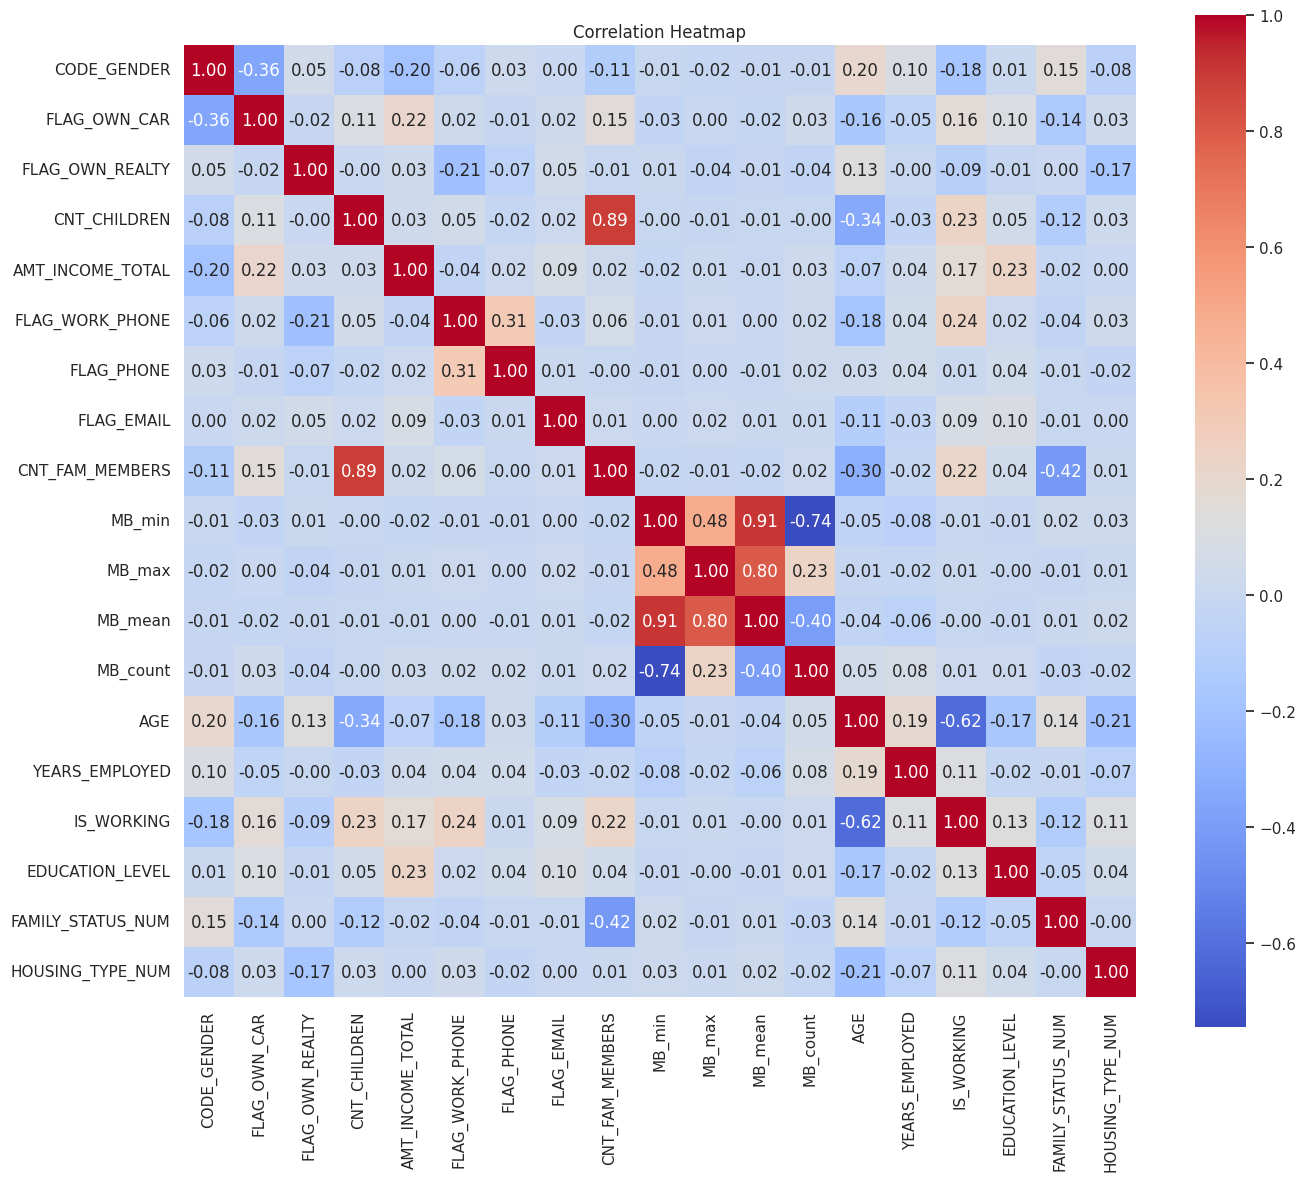

In [ ]:
corr = df[num_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
df.drop(columns=['MB_min', 'MB_max', 'CNT_CHILDREN'], inplace=True)

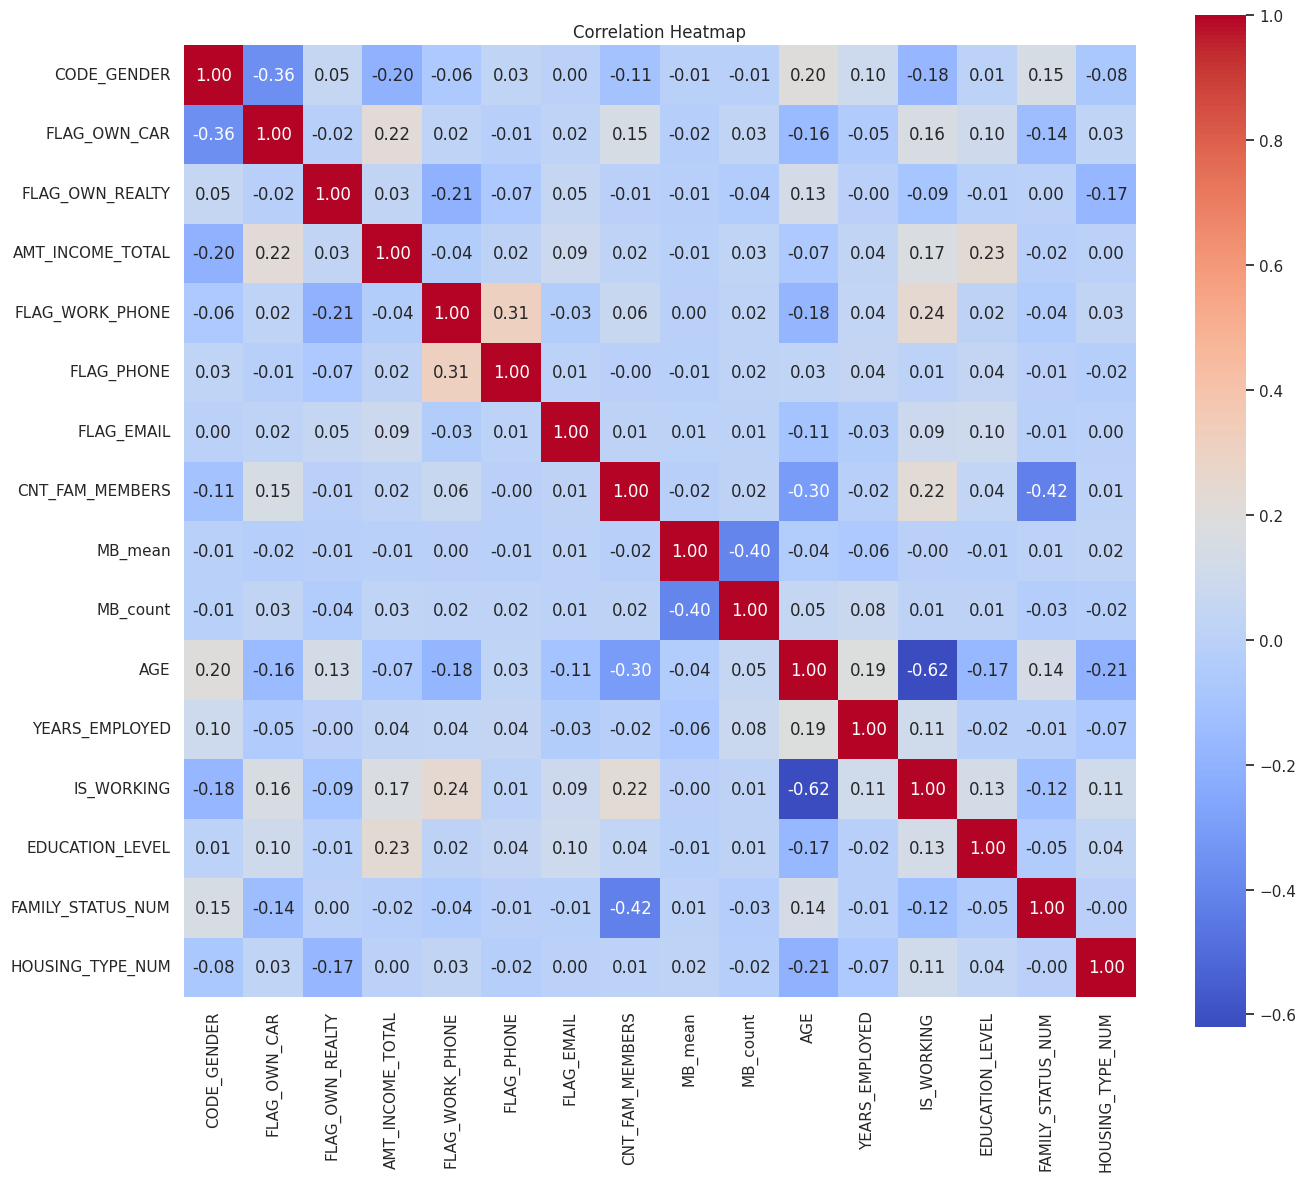

In [ ]:
# Update num_cols to reflect the current columns in df
num_cols = [col for col in num_cols if col in df.columns]

corr = df[num_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
FLAG_WORK_PHONE,0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])

# Update num_cols to only include columns present in df
num_cols = [col for col in num_cols if col in df.columns]

X_vif = add_constant(df[num_cols])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF_score"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data

,Feature,VIF_score
0,const,79.212302
1,CODE_GENDER,1.239939
2,FLAG_OWN_CAR,1.213129
3,FLAG_OWN_REALTY,1.089988
4,AMT_INCOME_TOTAL,1.164929
5,FLAG_WORK_PHONE,1.240083
6,FLAG_PHONE,1.125887
7,FLAG_EMAIL,1.032029
8,CNT_FAM_MEMBERS,1.328319
9,MB_mean,1.196560


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   36457 non-null  int64   
 1   CODE_GENDER          36457 non-null  int64   
 2   FLAG_OWN_CAR         36457 non-null  int64   
 3   FLAG_OWN_REALTY      36457 non-null  int64   
 4   AMT_INCOME_TOTAL     36457 non-null  float64 
 5   NAME_INCOME_TYPE     36457 non-null  object  
 6   NAME_EDUCATION_TYPE  36457 non-null  object  
 7   NAME_FAMILY_STATUS   36457 non-null  object  
 8   NAME_HOUSING_TYPE    36457 non-null  object  
 9   FLAG_WORK_PHONE      36457 non-null  int64   
 10  FLAG_PHONE           36457 non-null  int64   
 11  FLAG_EMAIL           36457 non-null  int64   
 12  OCCUPATION_TYPE      36457 non-null  object  
 13  CNT_FAM_MEMBERS      36457 non-null  int64   
 14  approved             36457 non-null  object  
 15  MB_mean            

In [ ]:
# Drop the 'age_group' and 'income_bin' column which was used for EDA and contains string values
df.drop(columns=['ID', 'age_group', 'income_bin'], inplace=True)

# Preprocessing

## === Train-Test Split, Encoding dan Scaling ===

In [ ]:
target_column = 'approved'
y = df[target_column].map({'Yes': 1, 'No': 0})
X = df.drop(columns=[target_column])

In [ ]:
# Pisahkan kolom kategorikal dan numerikal
cat_cols = X.select_dtypes(include=['object',
                                    'category']
                           ).columns.tolist()
num_cols = X.select_dtypes(include=np.number
                           ).columns.tolist()

In [ ]:
cat_cols

['NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [ ]:
num_cols

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'MB_mean',
 'MB_count',
 'AGE',
 'YEARS_EMPLOYED',
 'IS_WORKING',
 'EDUCATION_LEVEL',
 'FAMILY_STATUS_NUM',
 'HOUSING_TYPE_NUM']

In [ ]:
# One-Hot Encoding
X = pd.get_dummies(X, columns=cat_cols,
                   drop_first=True)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=11,
    stratify=y
)

In [ ]:
X_train.shape

(29165, 50)

In [ ]:
X_test.shape

(7292, 50)

In [ ]:
num_cols_final = [col for col in num_cols if col in X_train.columns]

In [ ]:
# Scaling numerik
scaler = StandardScaler()
X_train[num_cols_final] = scaler.fit_transform(
    X_train[num_cols_final])
X_test[num_cols_final] = scaler.transform(
    X_test[num_cols_final])

In [ ]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MB_mean,MB_count,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0,1,1,427500.0,1,0,0,2,-7.5,16,...,True,False,False,False,False,False,False,False,False,False
1,0,1,1,427500.0,1,0,0,2,-7.0,15,...,True,False,False,False,False,False,False,False,False,False
2,0,1,1,112500.0,0,0,0,2,-14.5,30,...,False,False,False,False,False,False,False,False,True,False
3,1,0,1,270000.0,0,1,1,1,-2.0,5,...,False,False,False,False,False,False,True,False,False,False
4,1,0,1,270000.0,0,1,1,1,-24.0,5,...,False,False,False,False,False,False,True,False,False,False


# Modeling

Membangun dan mengevaluasi model klasifikasi menggunakan:
- Logistic Regression
- Random Forest Classifier
- XGBoost

Metode evaluasi:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC AUC

In [ ]:
print("==== Baseline Model ====")
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("Dummy Classifier Performance:")
print(classification_report(y_test, y_dummy))

==== Baseline Model ====
Dummy Classifier Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       858
           1       0.88      1.00      0.94      6434

    accuracy                           0.88      7292
   macro avg       0.44      0.50      0.47      7292
weighted avg       0.78      0.88      0.83      7292



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## === Modeling and Evaluation (tanpa SMOTE) ===

In [ ]:
# Inisialisasi model
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    random_state=42
)

lgbm = LGBMClassifier(
    class_weight='balanced',
    random_state=42
)

# Evaluasi semua model
print("\n==== Model Performance Sebelum SMOTE ====\n")
models = [logreg, rf, xgb, lgbm]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred, labels=[1, 0]))


==== Model Performance Sebelum SMOTE ====


Logistic Regression Performance:
              precision    recall  f1-score   support

           1       0.91      0.61      0.73      6434
           0       0.16      0.55      0.24       858

    accuracy                           0.60      7292
   macro avg       0.53      0.58      0.49      7292
weighted avg       0.82      0.60      0.67      7292


Random Forest Performance:
              precision    recall  f1-score   support

           1       0.91      0.98      0.94      6434
           0       0.62      0.24      0.35       858

    accuracy                           0.89      7292
   macro avg       0.76      0.61      0.65      7292
weighted avg       0.87      0.89      0.87      7292



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:23:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Performance:
              precision    recall  f1-score   support

           1       0.93      0.74      0.83      6434
           0       0.22      0.55      0.32       858

    accuracy                           0.72      7292
   macro avg       0.57      0.65      0.57      7292
weighted avg       0.84      0.72      0.77      7292

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25732, number of negative: 3433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 29165, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM Perfo

## === Modeling and Evaluation (dengan SMOTE) ===

In [ ]:
# === Oversampling with SMOTE ===
print("\n==== Setelah SMOTE ====")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Inisialisasi model
logreg_sm = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf_sm = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb_sm = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=1,  # Karena sudah di-SMOTE, tidak perlu adjustment
    use_label_encoder=False,
    random_state=42
)
lgbm_sm = LGBMClassifier(
    class_weight='balanced',
    random_state=42
)

# Daftar model dan nama
models_sm = [logreg_sm, rf_sm, xgb_sm, lgbm_sm]
model_names_sm = ['Logistic Regression (SMOTE)', 'Random Forest (SMOTE)', 'XGBoost (SMOTE)', 'LightGBM (SMOTE)']

# Training & evaluasi
for model, name in zip(models_sm, model_names_sm):
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred, labels=[1, 0]))


==== Setelah SMOTE ====

Logistic Regression (SMOTE) Performance:
              precision    recall  f1-score   support

           1       0.89      0.82      0.85      6434
           0       0.15      0.23      0.18       858

    accuracy                           0.75      7292
   macro avg       0.52      0.53      0.52      7292
weighted avg       0.80      0.75      0.77      7292


Random Forest (SMOTE) Performance:
              precision    recall  f1-score   support

           1       0.92      0.95      0.93      6434
           0       0.50      0.36      0.42       858

    accuracy                           0.88      7292
   macro avg       0.71      0.66      0.68      7292
weighted avg       0.87      0.88      0.87      7292



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:23:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (SMOTE) Performance:
              precision    recall  f1-score   support

           1       0.89      0.97      0.93      6434
           0       0.40      0.14      0.21       858

    accuracy                           0.87      7292
   macro avg       0.65      0.56      0.57      7292
weighted avg       0.84      0.87      0.85      7292

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25732, number of negative: 25732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3657
[LightGBM] [Info] Number of data points in the train set: 51464, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM (SMOTE) Performance:
              precision    re

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 1. Logistic Regression - Hyperparameter Tuning
logreg_param = [
    {
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'l1_ratio': [None]
    },
    {
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.3, 0.5, 0.7]
    }
]

logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_search = RandomizedSearchCV(
    logreg,
    logreg_param,
    scoring='f1_macro',
    cv=5,
    n_iter=20,
    random_state=42,
    n_jobs=-1
)
logreg_search.fit(X_train_smote, y_train_smote)
logreg_best = logreg_search.best_estimator_

# 2. Random Forest - Hyperparameter Tuning
rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Param grid Random Forest
rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1],
    'model__max_features': [None, 'sqrt'],
    'model__bootstrap': [True]
}

# GridSearchCV untuk Random Forest
grid_search_rf = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search_rf.fit(X_train_smote, y_train_smote)
rf_best = grid_search_rf.best_estimator_

# Test Set Evaluation
y_test_pred_rf_tuned = rf_best.predict(X_test)
print("\n=== Random Forest (Tuned) - Test Set ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf_tuned))
print(confusion_matrix(y_test, y_test_pred_rf_tuned))
print(classification_report(y_test, y_test_pred_rf_tuned))

# 3. XGBoost - Hyperparameter Tuning
# Pipeline untuk XGBoost
xgb_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # atau ganti dengan 'preprocessor' jika ada
    ('model', XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=42
    ))
])

# Parameter grid XGBoost
xgb_param_grid = {
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__n_estimators': [100, 200],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8],
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search_xgb.fit(X_train_smote, y_train_smote)
xgb_best = grid_search_xgb.best_estimator_

# Test Set Evaluation
y_test_pred_xgb_tuned = xgb_best.predict(X_test)
print("\n=== XGBoost (Tuned) - Test Set ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb_tuned))
print(confusion_matrix(y_test, y_test_pred_xgb_tuned))
print(classification_report(y_test, y_test_pred_xgb_tuned))

# === Evaluasi Model ===
models_tuned = [logreg_best, rf_best, xgb_best]
model_names_tuned = ['Logistic Regression (Tuned)', 'Random Forest (Tuned)', 'XGBoost (Tuned)']

for model, name in zip(models_tuned, model_names_tuned):
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred, labels=[1, 0]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== Random Forest (Tuned) - Test Set ===
Accuracy: 0.8834339001645639
[[ 303  555]
 [ 295 6139]]
              precision    recall  f1-score   support

           0       0.51      0.35      0.42       858
           1       0.92      0.95      0.94      6434

    accuracy                           0.88      7292
   macro avg       0.71      0.65      0.68      7292
weighted avg       0.87      0.88      0.87      7292

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:46:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (Tuned) - Test Set ===
Accuracy: 0.8575150850246845
[[ 126  732]
 [ 307 6127]]
              precision    recall  f1-score   support

           0       0.29      0.15      0.20       858
           1       0.89      0.95      0.92      6434

    accuracy                           0.86      7292
   macro avg       0.59      0.55      0.56      7292
weighted avg       0.82      0.86      0.84      7292


Logistic Regression (Tuned) Performance:
              precision    recall  f1-score   support

           1       0.89      0.81      0.85      6434
           0       0.15      0.24      0.18       858

    accuracy                           0.74      7292
   macro avg       0.52      0.53      0.52      7292
weighted avg       0.80      0.74      0.77      7292


Random Forest (Tuned) Performance:
              precision    recall  f1-score   support

           1       0.92      0.95      0.94      6434
           0       0.51      0.35      0.42       858

    accuracy

In [ ]:
print("Best params LogisticRegression:", logreg_search.best_params_)
print("Best params RandomForest:", rf_search.best_params_)
print("Best params XGBoost:", xgb_search.best_params_)

Best params LogisticRegression: {'solver': 'liblinear', 'penalty': 'l1', 'l1_ratio': None, 'C': 0.1}


NameError: name 'rf_search' is not defined

In [ ]:
score = cross_val_score(xgb_sm, X_train_smote, y_train_smote, cv=5, scoring='f1')
print("Average F1 Score (CV):", score.mean())

score = cross_val_score(rf_sm, X_train_smote, y_train_smote, cv=5, scoring='f1')
print("Average F1 Score (CV):", score.mean())

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


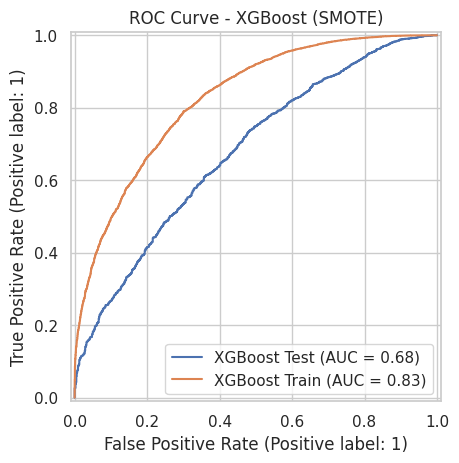

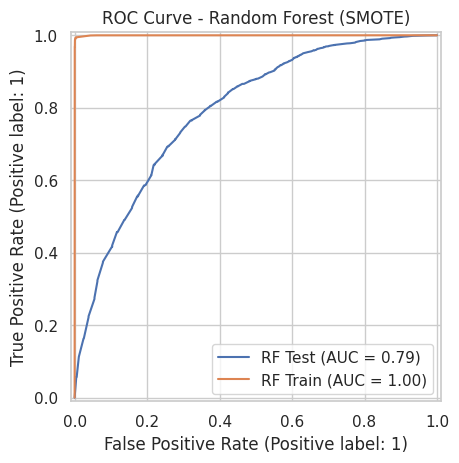

In [ ]:
xgb_sm.fit(X_train_smote, y_train_smote)
roc_display = RocCurveDisplay.from_estimator(xgb_sm, X_test, y_test, name='XGBoost Test')
RocCurveDisplay.from_estimator(xgb_sm, X_train, y_train, name='XGBoost Train', ax=roc_display.ax_)
plt.title("ROC Curve - XGBoost (SMOTE)")
plt.show()

rf_sm.fit(X_train_smote, y_train_smote)
roc_display = RocCurveDisplay.from_estimator(rf_sm, X_test, y_test, name='RF Test')
RocCurveDisplay.from_estimator(rf_sm, X_train, y_train, name='RF Train', ax=roc_display.ax_)
plt.title("ROC Curve - Random Forest (Tuned)")
plt.show()

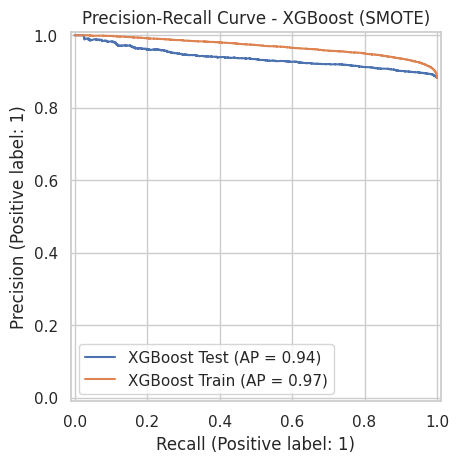

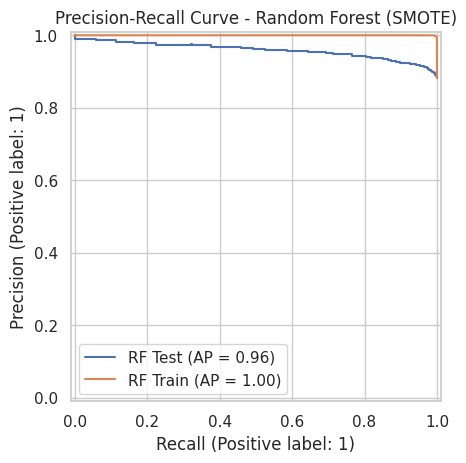

In [ ]:
pr_display = PrecisionRecallDisplay.from_estimator(xgb_sm, X_test, y_test, name='XGBoost Test')
PrecisionRecallDisplay.from_estimator(xgb_sm, X_train, y_train, name='XGBoost Train', ax=pr_display.ax_)
plt.title("Precision-Recall Curve - XGBoost (SMOTE)")
plt.show()

pr_display = PrecisionRecallDisplay.from_estimator(rf_sm, X_test, y_test, name='RF Test')
PrecisionRecallDisplay.from_estimator(rf_sm, X_train, y_train, name='RF Train', ax=pr_display.ax_)
plt.title("Precision-Recall Curve - Random Forest (SMOTE)")
plt.show()

<Figure size 1000x800 with 0 Axes>

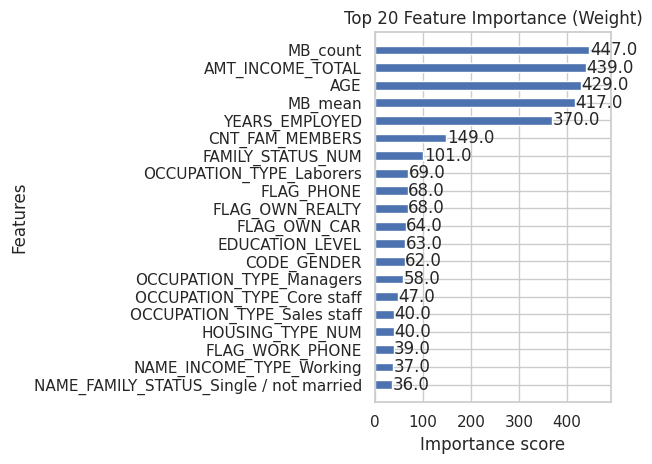

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(
    xgb_sm,
    importance_type='weight',
    max_num_features=20,
    height=0.5,
    show_values=True,
    grid=True
)
plt.title("Top 20 Feature Importance (Weight)")
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

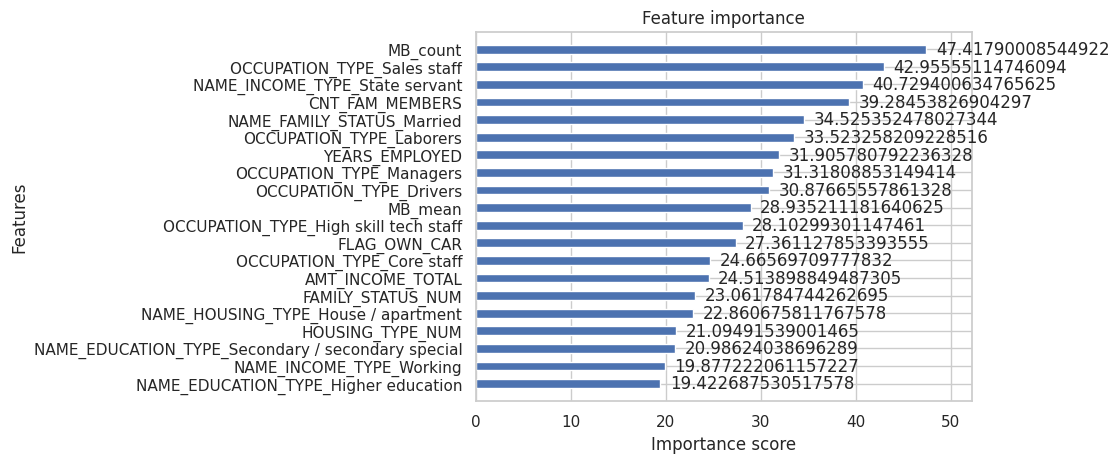

In [ ]:
plot_importance(
    xgb_sm,
    importance_type='gain',
    max_num_features=20,
    height=0.5,
    show_values=True,
    grid=True
)

/tmp/ipython-input-3855959152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')


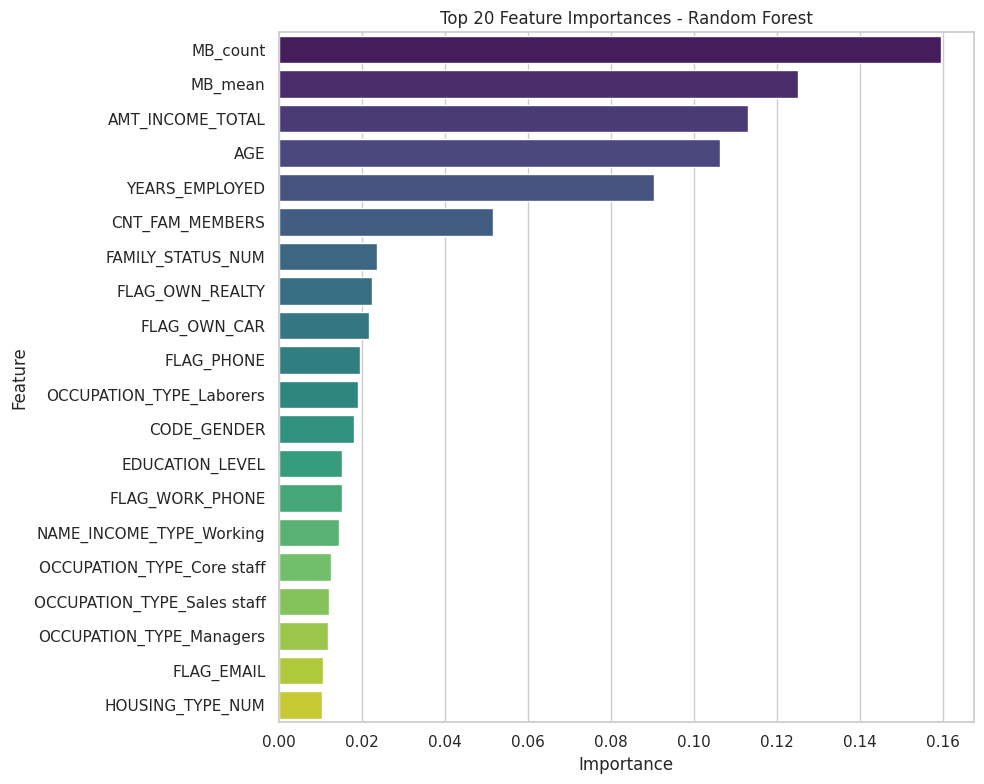

In [ ]:
importances = rf_sm.feature_importances_
feature_names = X_train.columns

# Buat dataframe
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Urutkan dari paling penting
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
X_train.dtypes.value_counts()


,count
bool,34
float64,16


In [ ]:
X_train = X_train.astype(float)


In [ ]:
import shap

explainer = shap.TreeExplainer(
    model=xgb_sm,
    data=X_train,
    feature_perturbation='interventional',
    model_output='probability'
)

shap_values = explainer.shap_values(X_train)

100%|===================| 29031/29165 [02:28<00:00]       

In [ ]:

explainer = shap.Explainer(rf_only, X_train_transformed)
shap_values = explainer(X_train_transformed, check_additivity=False)

NameError: name 'X_train_transformed' is not defined

In [ ]:
shap.summary_plot(
    shap_values, X_train,
    plot_type='bar',
    show=False
)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()
plt.show()

In [ ]:
shap.summary_plot(
    shap_values, X_train,
    show=False
)
plt.title("SHAP Beeswarm Plot")
plt.tight_layout()
plt.show()

In [ ]:
shap.dependence_plot(
    'MB_count',
    shap_values,
    X_train,
    interaction_index=None
)

In [ ]:
explanation = explainer(X_train)
shap.plots.waterfall(explanation[11])

In [ ]:
importances = xgb_sm.feature_importances_
feat_names = X_train.columns
feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_imp_df.sort_values(by='importance', ascending=False).head(10)


In [ ]:
sample = X_test.sample(1, random_state=10)
prediction = model.predict(sample)[0]
print("Hasil Prediksi:", "Layak Kredit" if prediction == 1 else "Tidak Layak Kredit")

# Evaluation

Model dievaluasi berdasarkan performa pada data testing. Hasil terbaik menunjukkan bahwa model mampu memisahkan pemohon layak dan tidak layak dengan cukup akurat.

Model yang dipilih: **XGBoost + SMOTE**

# Business Insight & Deployment

Model ini dapat diintegrasikan ke dalam sistem persetujuan kartu kredit untuk:
- Menyaring aplikasi secara otomatis
- Memberi alert pada pengajuan dengan risiko tinggi
- Menghemat waktu verifikasi manual

**Catatan:** Model perlu dipantau secara berkala dan di-retrain agar tetap relevan seiring perubahan tren

# Insight dan Rekomendasi

- XGBoost + SMOTE memberikan performa terbaik (AUC > 0.80).
- Fitur penting: aktivitas finansial pemohon, lama bekerja, usia, pendapatan, pekerjaan, dan kepemilikan rumah.
- Dengan model ini, proses penyaringan aplikasi kredit dapat dipercepat dan lebih akurat.
- Disarankan mengintegrasikan model ke sistem evaluasi kredit internal.
